In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import re
from torch.nn.functional import one_hot
from torch.amp import autocast
from scipy.stats import spearmanr

from MSA_Pairformer.model import MSAPairformer
from MSA_Pairformer.dataset import aa2tok_d, prepare_msa_masks
from MSA_Pairformer.proteingym_utils import process_msa, sample_msa, label_row

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load model

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(device) if device.type == 'cuda' else 'CPU'
print(f"Using device: {device_name}")
model = MSAPairformer.from_pretrained(device=device).to(torch.bfloat16)
model.eval()
model = torch.compile(model, dynamic=True)

Using device: NVIDIA GH200 480GB


Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 89240.51it/s]


## Load and prepare data

In [ ]:
# File paths
msa_file = "../data/proteingym_example/A0A2Z5U3Z0_9INFA_theta0.99_full_11-26-2021_b09.a2m"
msa_weights_file = "../data/proteingym_example/A0A2Z5U3Z0_9INFA_theta_0.01.npy"
dms_file = "../data/proteingym_example/A0A2Z5U3Z0_9INFA_Wu_2014.csv"

# Load MSA using ProteinGym methodology
nSeqs = 512
filter_msa = False
hhfilter_min_cov = 75
hhfilter_max_seq_id = 90
hhfilter_min_seq_id = 30
num_cpus = 48
path_to_hhfilter = "hhfilter" # Replace with path to hhfilter binary if necessary
processed_msa = process_msa(
    filename=msa_file,
    weight_filename=msa_weights_file,
    filter_msa=False,
    hhfilter_min_cov=hhfilter_min_cov,
    hhfilter_max_seq_id=hhfilter_max_seq_id,
    hhfilter_min_seq_id=hhfilter_min_seq_id,
    hhfilter_bin=path_to_hhfilter,
    num_cpus=num_cpus
)
seed = "0"
msa_sampling_strategy = "sequence-reweighting"
nSeqs = 512
data = [
    sample_msa(
        sampling_strategy=msa_sampling_strategy,
        filename=msa_file,
        nseq=nSeqs,
        weight_filename=msa_weights_file,
        processed_msa=processed_msa,
        random_seed=seed,
        num_cpus=num_cpus
    )
]
nTokenTypes = len(np.unique(list(aa2tok_d.values())))
seq_l = [data[0][i][1] for i in range(len(data[0]))]
seq_a = np.array([list(seq) for seq in seq_l])
offset_idx = 1 # Since DMS positions are 1-indexed, but MSA positions are 0-indexed
wt_seq = seq_l[0] # Wild-type sequence
# Prepare MSA input tensors
tokenized_msa_t = torch.from_numpy(np.vectorize(aa2tok_d.get)(seq_a))
mask, msa_mask, full_mask, pairwise_mask = prepare_msa_masks(tokenized_msa_t.unsqueeze(0))
mask = mask.to(device)
msa_mask = msa_mask.to(device)
full_mask = full_mask.to(device)
pairwise_mask = pairwise_mask.to(device)

Number of sequences in MSA (before preprocessing): 57581
Calculating proportion of gaps
Proportion of sequences dropped due to fraction of gaps: 0.0%
Proportion of non-focus columns removed: 0.0%
Proportion of sequences dropped due to indeterminate AAs: 8.58%
Number of sequences after preprocessing: 52640
Data Shape = (52640, 565, 20)
Loading sequence weights from disk: ../data/proteingym_example/A0A2Z5U3Z0_9INFA_theta_0.01.npy
Neff = 9047.200739545102
Number of sequences:  52640
Name of focus_seq: >A0A2Z5U3Z0_9INFA/1-565
Sampling sequences from MSA with strategy: sequence-reweighting
Check sum weights MSA: 0.9999999999999999


In [4]:
# Load DMS data
dms_df = pd.read_csv(dms_file)
dms_positions = set(dms_df["mutant"].map(lambda x: re.findall(r'[A-Z](\d+)[A-Z]', x)).explode().astype(int).tolist())
dms_df

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,L6V,MKAKLVVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.000000,0
1,L6F,MKAKLFVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.133090,1
2,L6S,MKAKLSVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.110407,1
3,L6I,MKAKLIVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,1.002017,1
4,Y10F,MKAKLLVLLFAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.296503,1
...,...,...,...,...
2345,L559S,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.034448,0
2346,L559M,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.609097,1
2347,Q560E,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.060911,0
2348,Q560R,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,0.224415,1


## Predict amino acid probabilities for each position in the sequence
Mask each position in the sequence and predict profile

In [6]:
all_token_probs = []
for i in tqdm(range(tokenized_msa_t.size(1)), desc="Scoring masked-marginals"):
    # Skip if position is not in DMS
    if i + offset_idx not in dms_positions:
        zero_t = torch.zeros((1, nTokenTypes-2)) # -2 to remove <pad> and <mask>
        all_token_probs.append(zero_t)
        continue
    tokenized_msa_masked_t = tokenized_msa_t.clone()
    tokenized_msa_masked_t[0, i] = aa2tok_d['<mask>']  # mask out first sequence
    with torch.no_grad():
        msa_masked_onehot_t = one_hot(tokenized_msa_masked_t, num_classes=nTokenTypes).bfloat16().unsqueeze(0).to(device)
        with autocast(dtype=torch.bfloat16, device_type="cuda"):
            token_probs = torch.log_softmax(
                model(
                    msa=msa_masked_onehot_t,
                    return_seq_weights=False,
                    return_contacts=False,
                    query_only=True,
                    mask=mask,
                    msa_mask=msa_mask,
                    full_mask=full_mask,
                    pairwise_mask=pairwise_mask
                )['logits'],
                dim=-1
            )
    all_token_probs.append(token_probs[:, 0, i].detach().cpu())  # vocab size
token_probs = torch.cat(all_token_probs, dim=0).unsqueeze(0)
dms_df[f"MSA_Pairformer_Score"] = dms_df.apply(
    lambda row: label_row(
        row["mutant"], wt_seq, token_probs.detach().cpu(), aa2tok_d, offset_idx
    ),
    axis=1,
)

Scoring masked-marginals: 100%|██████████| 565/565 [08:43<00:00,  1.08it/s]


Spearman's rho: 0.5229655706729988, p-value: 3.9184956725018025e-165


/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


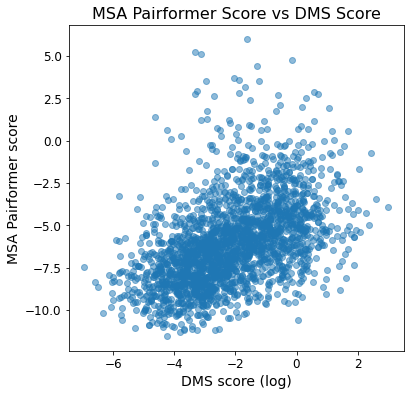

In [7]:
rho, pval = spearmanr(dms_df["MSA_Pairformer_Score"], dms_df["DMS_score"])
print(f"Spearman's rho: {rho}, p-value: {pval}")
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.log(dms_df["DMS_score"]), dms_df["MSA_Pairformer_Score"], alpha=0.5)
ax.set_xlabel("DMS score (log)", fontsize=14)
ax.set_ylabel("MSA Pairformer score", fontsize=14)
ax.set_title("MSA Pairformer Score vs DMS Score", size=16)
ax.tick_params(labelsize=12)